In [72]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)

model.eval()

def transform_image(image):
    image = F.to_tensor(image)
    return image.unsqueeze(0)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [102]:
def calculate_area(box):
  maxX = max(box[0], box[2])
  maxY = max(box[1], box[3])
  minX = min(box[0], box[2])
  minY = min(box[1], box[3])
  width = (maxX-minX)
  height = (maxY-minY)
  return width*height

In [103]:
def calculate_iou(box1, box2):
    # Calculate the intersection area
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate the union area
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union_area = box1_area + box2_area - intersection_area

    # Calculate the IoU
    iou = intersection_area / union_area
    return iou

In [104]:
def max_area_box(boxes, threshold):
  maxArea = []
  maxAreaBox = []
  for box1 in boxes:
    for box2 in boxes:
      if box1 != box2:
        iou = calculate_iou(box1, box2)
        if iou < threshold:
          calAB1 = calculate_area(box1)
          calAB2 = calculate_area(box2)
          maxBox = max(calAB1, calAB2)
          # print(maxBox)
          if maxBox not in maxArea:
            maxArea.append(maxBox)
          if maxBox == calAB1:
            if box1 not in maxAreaBox:
              maxAreaBox.append(box1)
          if maxBox == calAB2:
            if box2 not in maxAreaBox:
              maxAreaBox.append(box2)

    return {"MaxArea":maxArea, "MaxAreaBox":maxAreaBox}

In [121]:
def detect_object(img, threshold):
  image_path = img
  image = Image.open(image_path).convert("RGB")
  transformed_image = transform_image(image)

  with torch.no_grad():
      predictions = model(transformed_image)

  boxes = predictions[0]['boxes'].tolist()
  scores = predictions[0]['scores'].tolist()
  labels = predictions[0]['labels'].tolist()

  draw = ImageDraw.Draw(image)
  # print(max_area_box(boxes)['MaxAreaBox'])
  for box in max_area_box(boxes, threshold)['MaxAreaBox']:
    draw.rectangle(box, outline='red', width=3)

  image.show()
  # print(score)

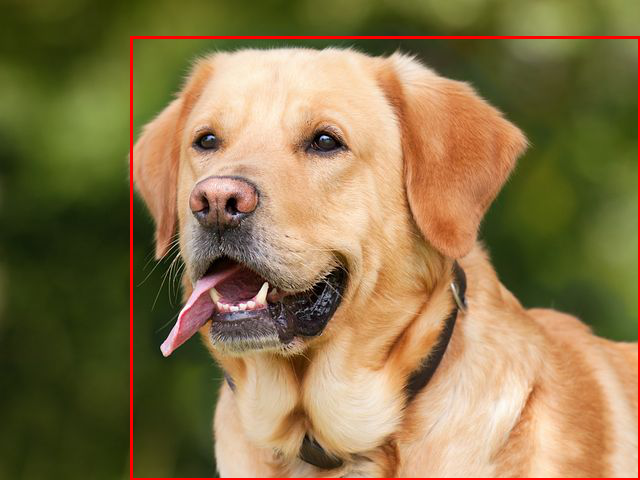

In [123]:
detect_object('/content/dog.jpg', 0.3)

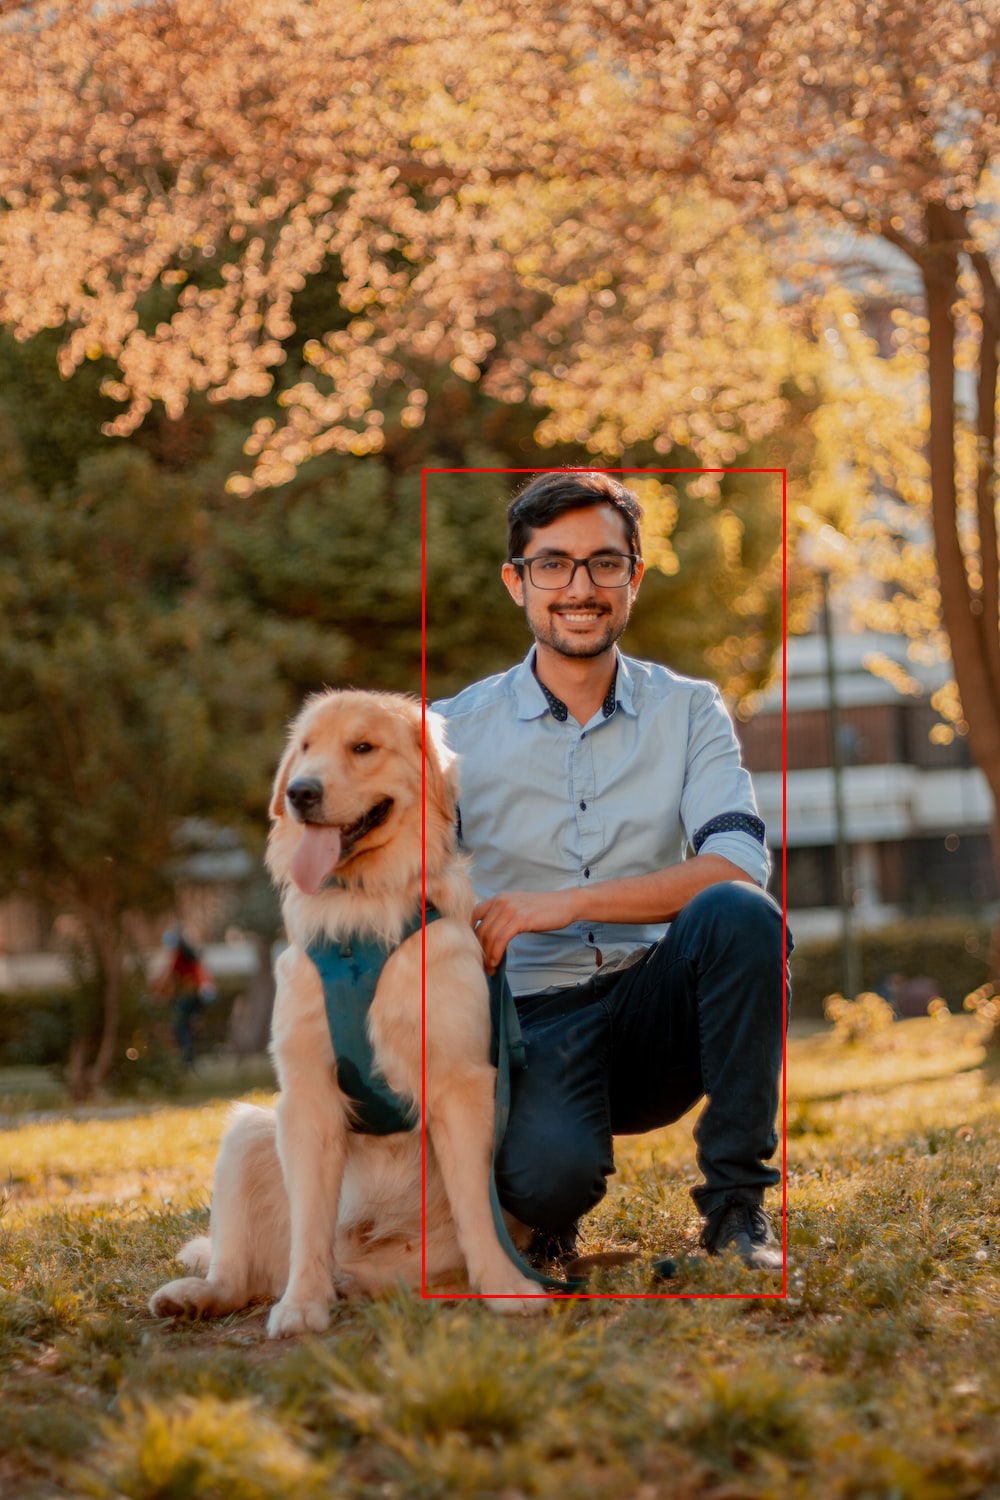

In [124]:
detect_object('/content/manwithdog.jpeg', 0.36)